# Week 5 Seminar.

## Chapter 6. Linear model selection & regularization. ISLP textbook.

### Course: ML with Python, 2024/2025, HSE
### Author: Maria Tikhonova, Oleg Melnikov, teaching team.

In this seminar we'll work with the new dataset about microchips (finally, not Titanic!) and practice regularization technics which help to improve the regression quality.

**Keywords:** regularization, L2-regularization, L1-regularization, regression, lasso regression, ridge regression.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns, numpy as np, pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import \
  cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit, KFold, ShuffleSplit,\
  StratifiedKFold, GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit
from matplotlib.patches import Patch
sns.set()

## Prerequisites: dataset loading & EDA

Let's load the data using `read_csv` from the `pandas` library.

This dataset contains information about 118 microchips (objects), their results for two tests of quality control (two numerical variables) and information whether the microchip went into production (target variable).

**Our goal:** to predict whether the chip went into production or not, based on two quality control tests.


In [ ]:
# loading data
data = pd.read_csv('https://raw.githubusercontent.com/omelnikov/data/main/microchip/microchip.txt')
data.columns = ['test1','test2','released']
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


**Let's perform standard EDA**

**Takeaway:** Luckily there are no missing values and all the atrributes are numerical. Moreover, average for both tests is close to zero, they lie in the same range and there are no outliers.

In [ ]:
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [ ]:
# method .round(2) make a rounding of output floats
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
test1,118.0,0.05,0.50,-0.83,-0.37,-0.01,0.48,1.07
test2,118.0,0.18,0.52,-0.77,-0.25,0.21,0.65,1.11
released,118.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00


In [ ]:
data.released.value_counts()

released
0    60
1    58
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

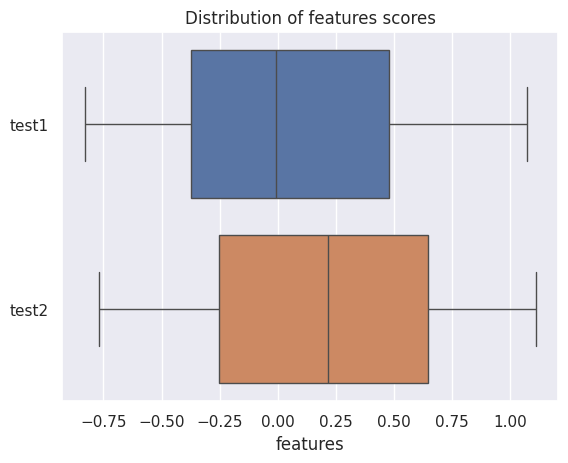

In [ ]:
plt.figure()
sns.boxplot(data=data[['test1','test2']], orient='h')
plt.title('Distribution of features scores')
plt.xlabel('features')
plt.show()

Let's look at the head of the DataFrame.

In [ ]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [ ]:
data[data.test2 > 0].released.value_counts()

,count
released,
1,37
0,33


# Visualizing the data

For convenience we will store features and the target class labels in separate NumPy arrays.

In [ ]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

**Why:** visualizing the data could give us some insights about class distributions.

**Takeaway:** we see that classes are NOT lineary separable. Realeased microchips (blue class) basically lie inside the Faulty (orange class) ones.

**Question:** will simple linear regression perform well on such dataset as it is? What could we do to make it work?

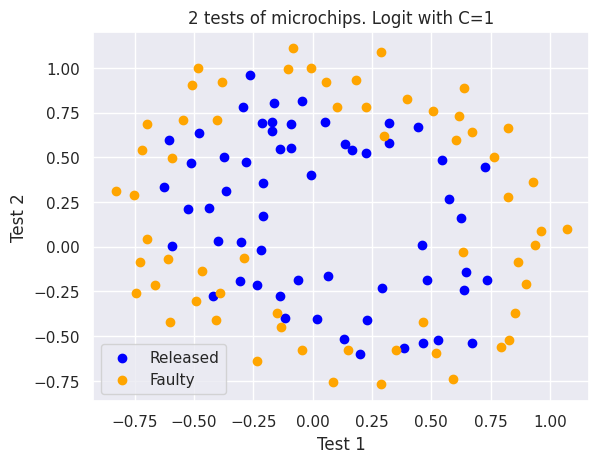

In [ ]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=1')
plt.legend();

Technical function to display the separating curve of the classifier.

In [ ]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))

    # to every point from [x_min, x_max]x[y_min, y_max]
    # we put in correspondence its own color
    # .ravel() -> Return a contiguous flattened array.
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

# Polynomial features

**Why:** one solution is to transform the dataset and to define polynomial features. Then applying linear regression to the transormed dataset will result in the non-linear bound in the original feature space.

**Recap:** We define the following polynomial features of degree $d$ for two variables $x_1$ and $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j\leq d, i,j \in \mathbb{N}}$$

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$


**Attention:** The number of such features is exponentially large, and it can be costly to build polynomial features of large degree (e.g $d=10$) for 100 variables. More importantly, it's not needed.


We will use `sklearn`'s implementation of polynimial transformation `PolynomialFeatures`. So, we create an object that will add polynomial features up to degree 7 to matrix $X$.

In [ ]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [ ]:
X[:10]

array([[ 0.051267,  0.69956 ],
       [-0.092742,  0.68494 ],
       [-0.21371 ,  0.69225 ],
       [-0.375   ,  0.50219 ],
       [-0.51325 ,  0.46564 ],
       [-0.52477 ,  0.2098  ],
       [-0.39804 ,  0.034357],
       [-0.30588 , -0.19225 ],
       [ 0.016705, -0.40424 ],
       [ 0.13191 , -0.51389 ]])

In [ ]:
X_poly.shape

(118, 36)

# Ridge regression

Ridge regression is very similar to least squares, except that the coefficients in ridge are estimated by minimizing a slightly different function:

$$\Large J(X, y, \beta) = \mathcal{L} + \lambda \sum_j\beta_j^2$$


- $\mathcal{L}$ is the least ordinary squares loss function summed over the entire dataset
- $\lambda \sum_j\beta_j^2$ is called $l_2$ penalty


where $\lambda ≥ 0$ is a tuning parameter, to be determined separately. As with least squares, ridge regression seeks coefficient estimates that fit the data well, by making the RSS (Residual Sum of Squares) small. However, the second term, $\lambda |\beta|^2$ , called a *shrinkage penalty*, is small when betas are close to zero, and so it has the effect of shrinking penalty the estimates of $\beta_j$ towards zero. The tuning parameter $\lambda$ serves to control
the relative impact of these two terms on the regression coefficient estimates. When $\lambda = 0$, the penalty term has no effect, and ridge regression will produce the least squares estimates. However, as $\lambda$ increases the impact of the shrinkage penalty grows, and the ridge regression coefficient estimates will approach zero.

OLS: Ordinary Least Squares


$\hat{\beta}_{\text{OLS}} = (X^TX)^{-1}X^Ty;\ \hat{y} = X\hat{\beta_{\text{OLS}}}$

$\hat{\beta}_{\text{Ridge}} = (X^TX + \lambda I)^{-1}X^Ty;\ \hat{y} = X\hat{\beta_{\text{Ridge}}}$



In the case of logistic regression, a reverse regularization coefficient

$C=\frac{1}{\lambda}$ is typically introduced.

# First experiments with ridge regression
**Why:** let's build several ridge regressions with different $C = [1e-2, 0.5, 1,100, 1000, 10000]$ to get the idea, how the parameter influences the model and then we discuss the results and the mathematical explanation for them.




In [ ]:
#X_poly[:, 1:] = (X_poly[:, 1:] - X_poly[:, 1:].mean(axis=0, keepdims=True)) / X_poly[:, 1:].std(axis=0, keepdims=True)

C =  0.01
Accuracy on training set: 0.627


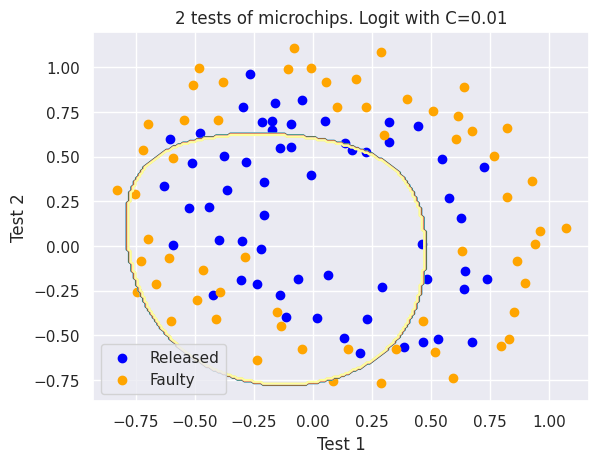





C =  0.5
Accuracy on training set: 0.831


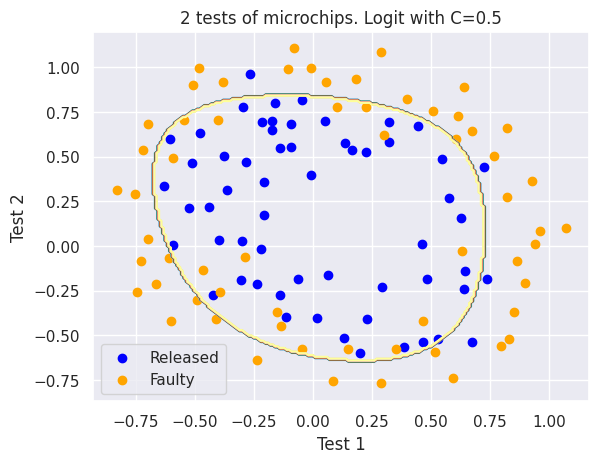





C =  1
Accuracy on training set: 0.831


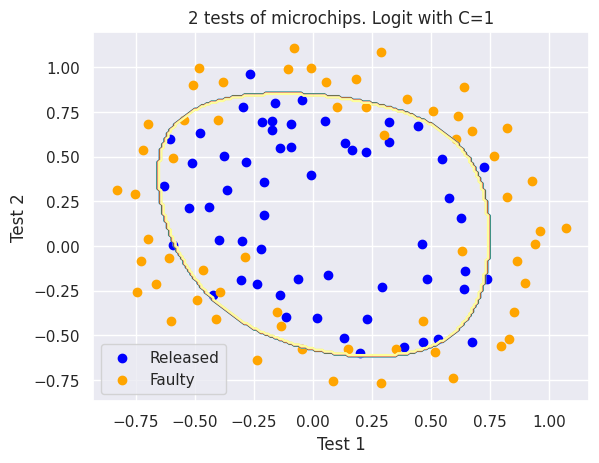





C =  100
Accuracy on training set: 0.839


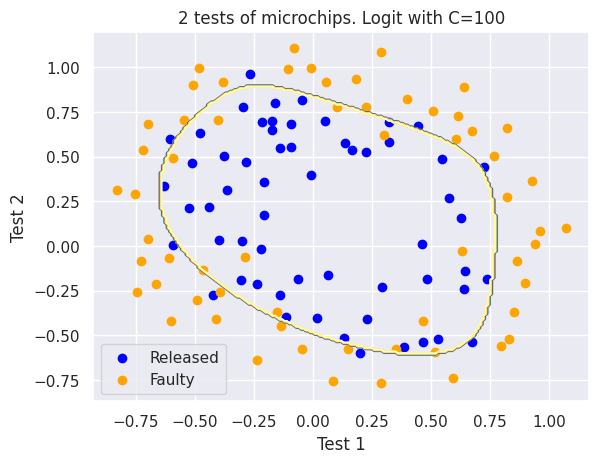





C =  1000
Accuracy on training set: 0.873


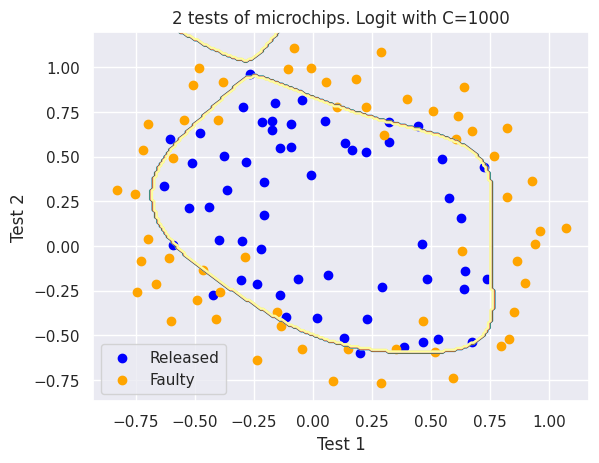





C =  10000
Accuracy on training set: 0.864


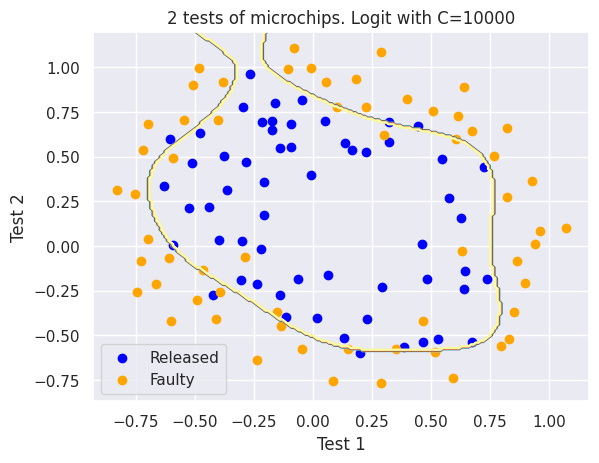

In [ ]:
Cs = [1e-2, 0.5, 1, 100, 1000, 10000]

for C in Cs:
    logit = LogisticRegression(C=C, penalty = 'l2', random_state=17, max_iter = 1000)
    logit.fit(X_poly, y)
    print('C = ', C)
    print("Accuracy on training set:",
          round(logit.score(X_poly, y), 3))
    plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title('2 tests of microchips. Logit with C=%s' % C)
    plt.legend()
    plt.show()
    print('\n\n\n')


To discuss the results, let's rewrite the function that is optimized in logistic regression with the form:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $C$ is the reverse regularization coefficient

**Takeaway**:
- the larger the parameter $C$, the more complex the relationships in the data that the model can recover (intuitively $C$ corresponds to the "complexity" of the model - model capacity)
- if regularization is too strong i.e. the values of $C$ are small, the solution to the problem of minimizing the logistic loss function may be the one where many of the weights are too small or zeroed. The model is also not sufficiently "penalized" for errors (i.e. in the function $J$, the sum of the squares of the weights "outweighs", and the error $\mathcal{L}$ can be relatively large). In this case, the model will underfit as we saw in our first case.
- on the contrary, if regularization is too weak i.e. the values of $C$ are large, a vector $w$ with high absolute value components can become the solution to the optimization problem. In this case, $\mathcal{L}$ has a greater contribution to the optimized functional $J$. Loosely speaking, the model is too "afraid" to be mistaken on the objects from the training set and will therefore overfit as we saw in the third case.
- logistic regression will not "understand" (or "learn") what value of $C$ to choose as it does with the weights $w$. That is to say, it can not be determined by solving the optimization problem in logistic regression. We have seen a similar situation before -- a decision tree can not "learn" what depth limit to choose during the training process. Therefore, $C$ is the a model hyperparameter that is tuned on cross-validation; so is the max_depth in a tree.

# Regularization parameter tuning

In order to find best value for parameter $C$ we will use cross-validation.

**Brief recap of cross-validation from the previous seminar**

In [ ]:
np.random.seed(0)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

def draw_bars(bars, y=0.5, vmin=-.2, vmax=1.2, label=None):
    ax = plt.gca()
    ax.scatter(range(len(bars)),  [y] * len(bars), c=bars, marker='_',
               lw=50, label=label, cmap=cmap_cv, vmin=vmin, vmax=vmax)

def plot_cv_splits(cv, index, title, y=None, groups=None):
    plt.figure()

    y_ticks_pos = []
    y_ticks = []
    for i, (train_idx, test_idx) in enumerate(cv.split(index, y=y, groups=groups)):
        idx_labels = np.array([(idx in train_idx) for idx in index])
        draw_bars(idx_labels, y=0.5+i)
        y_ticks_pos.append(0.5+i)
        y_ticks.append(f'Fold {i}')

    if y is not None:
        i += 1
        draw_bars(y, y=0.5+i, vmin=0.5, vmax=0.8)
        y_ticks_pos.append(0.5+i)
        y_ticks.append(f'Class')

    plt.xlabel('Observation index')
    plt.yticks(y_ticks_pos, y_ticks)
    plt.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
                ['Training set', 'Testing set'], loc=(1.02, .8))

    plt.ylim([0, i+1])
    plt.title(title)
    plt.show()

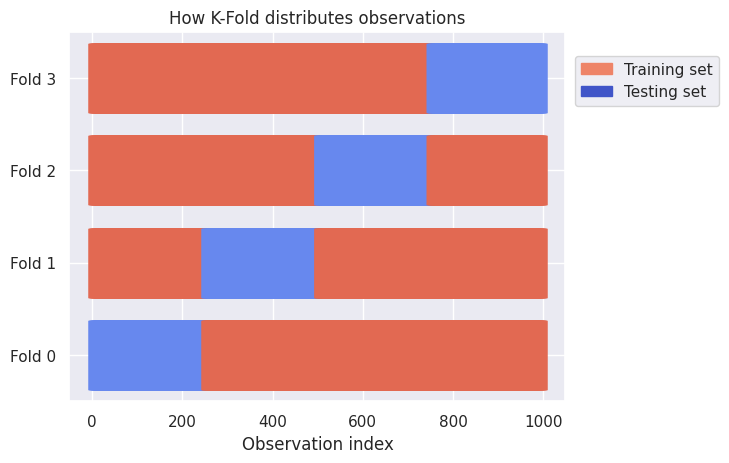

In [ ]:
cv = KFold(4, shuffle=False)
plot_cv_splits(cv, np.arange(1000), 'How K-Fold distributes observations')

# Grid search for parameter C

**Why:** Using this example, let's identify the optimal value of the regularization parameter $C$. This can be done using `LogisticRegressionCV` - a grid search of parameters followed by cross-validation. This class is designed specifically for logistic regression (effective algorithms with well-known search parameters). For an arbitrary model, use `GridSearchCV`, `RandomizedSearchCV`, or special algorithms for hyperparameter optimization such as the one implemented in `hyperopt`.

In [ ]:
np.logspace(-10, 10)

array([1.00000000e-10, 2.55954792e-10, 6.55128557e-10, 1.67683294e-09,
       4.29193426e-09, 1.09854114e-08, 2.81176870e-08, 7.19685673e-08,
       1.84206997e-07, 4.71486636e-07, 1.20679264e-06, 3.08884360e-06,
       7.90604321e-06, 2.02358965e-05, 5.17947468e-05, 1.32571137e-04,
       3.39322177e-04, 8.68511374e-04, 2.22299648e-03, 5.68986603e-03,
       1.45634848e-02, 3.72759372e-02, 9.54095476e-02, 2.44205309e-01,
       6.25055193e-01, 1.59985872e+00, 4.09491506e+00, 1.04811313e+01,
       2.68269580e+01, 6.86648845e+01, 1.75751062e+02, 4.49843267e+02,
       1.15139540e+03, 2.94705170e+03, 7.54312006e+03, 1.93069773e+04,
       4.94171336e+04, 1.26485522e+05, 3.23745754e+05, 8.28642773e+05,
       2.12095089e+06, 5.42867544e+06, 1.38949549e+07, 3.55648031e+07,
       9.10298178e+07, 2.32995181e+08, 5.96362332e+08, 1.52641797e+09,
       3.90693994e+09, 1.00000000e+10])

In [ ]:
np.logspace(-2, 3, 500)

array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62338243e-02, 1.66127252e-02, 1.70004698e-02,
       1.73972643e-02, 1.78033202e-02, 1.82188534e-02, 1.86440853e-02,
       1.90792422e-02, 1.95245558e-02, 1.99802631e-02, 2.04466067e-02,
       2.09238348e-02, 2.14122015e-02, 2.19119669e-02, 2.24233968e-02,
       2.29467637e-02, 2.34823460e-02, 2.40304289e-02, 2.45913043e-02,
       2.51652705e-02, 2.57526333e-02, 2.63537052e-02, 2.69688063e-02,
       2.75982639e-02, 2.82424133e-02, 2.89015972e-02, 2.95761666e-02,
       3.02664806e-02, 3.09729067e-02, 3.16958209e-02, 3.24356081e-02,
       3.31926620e-02, 3.39673858e-02, 3.47601918e-02, 3.55715021e-02,
      

In [ ]:
# creating CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-2, 3, 500)

# searching for best hyper-parameters
# n_jobs=-1 -> uses all available CPU cores to speed up computation
# verbose -> controls the output informations
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       6.45088409e+02, 6.60144909e+02, 6.75552832e+02, 6.91320378e+02,
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [ ]:
print('Best C = ', logit_searcher.C_[0])

Best C =  143.98479528760066


To see how the quality of the model (percentage of correct responses on the training and validation sets) varies with the hyperparameter $C$, we can plot the graph.

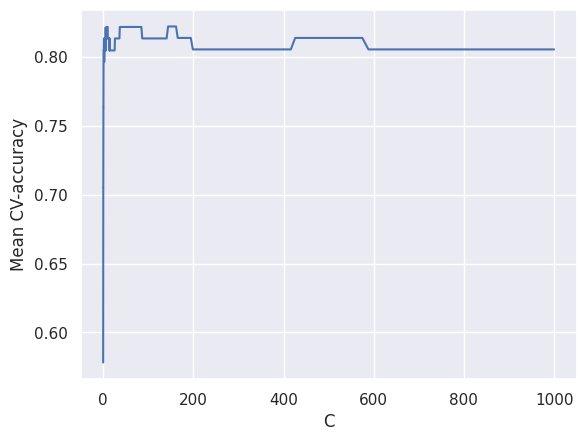

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
# ax.set_yscale('log')
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

# Model for best C

C =  143.98479528760066
Accuracy on training set: 0.847


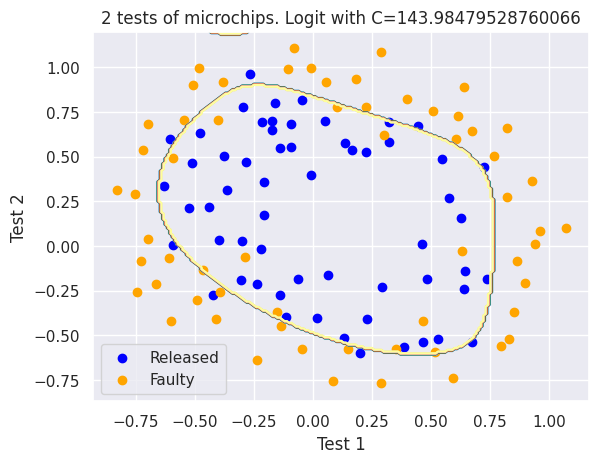

In [ ]:
C = logit_searcher.C_[0]
#C = 10000
logit = LogisticRegression(C=C, random_state=17, penalty = 'l2', max_iter = 1000)
logit.fit(X_poly, y)
print('C = ', C)
print("Accuracy on training set:",  round(logit.score(X_poly, y), 3))

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend()
plt.show()
print('\n\n\n')


**Best model coefficients**

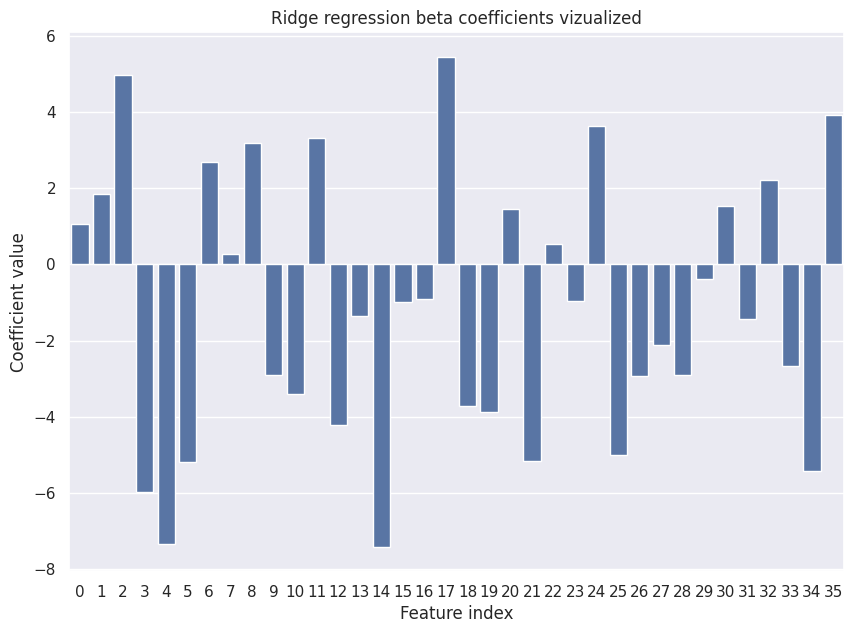

In [ ]:
coefs = logit.coef_[0]

plt.figure(figsize=(10, 7))
sns.barplot(y=coefs, x=list(range(len(coefs))))
plt.title('Ridge regression beta coefficients vizualized')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.show()

# Lasso regression

Ridge regression does have one obvious disadvantage. It does not do feature selection. Ridge regression
will include all p predictors in the final model. The penalty $\lambda |\beta|^2$ will shrink all of the coefficients towards zero, but it will not set any of them exactly to zero. This may not be a problem for prediction accuracy, but it can create a challenge in model interpretation in settings in which the number of variables p is quite large.

The lasso is an alternative to ridge regression that overcomes this disadvantage. The lasso minimizes the following function:


$$\Large J(X, y, \beta) = \mathcal{L} + \lambda \sum_j|\beta_j|$$

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $\lambda \sum_j|\beta_j|$ is called $l_1$ penalty

The lasso and ridge regression have similar formulations. The only difference is that the $\lambda\sum_j\beta_j^2 $ term in the ridge regression penalty has been replaced by $\lambda\sum_j|\beta_j|$ in the lasso penalty.

As with ridge regression, the rigde shrinks the coefficient estimates towards zero. However, in the case of the lasso, the penalty has the effect of forcing some of the coefficient estimates to be exactly equal to zero when
the tuning parameter $\lambda$ is sufficiently large. Hence, much like best subset selection, the lasso performs *variable selection*.

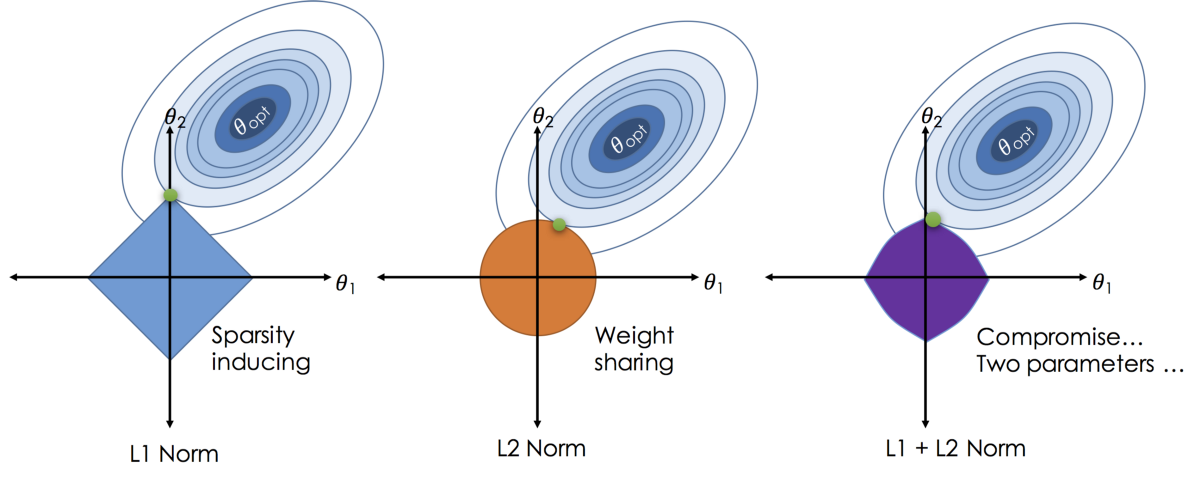

# First experiments with lasso regression
**Why:** let's repeat the same experiments for lasso regression and build several models with different $C = [0.5, 1,100, 1000, 10000]$.

In [ ]:
LogisticRegression?

C =  0.5
Accuracy on training set: 0.763


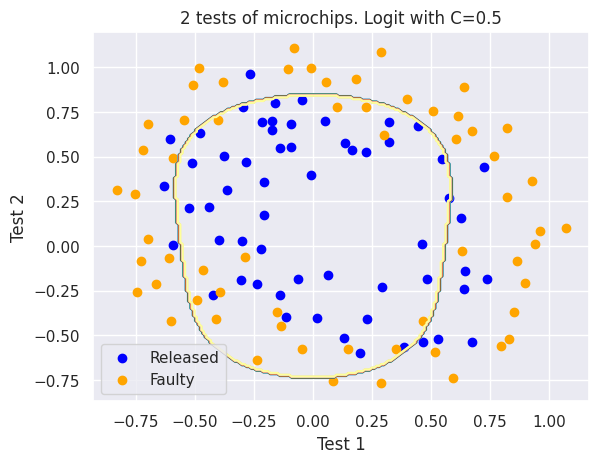





C =  1
Accuracy on training set: 0.797


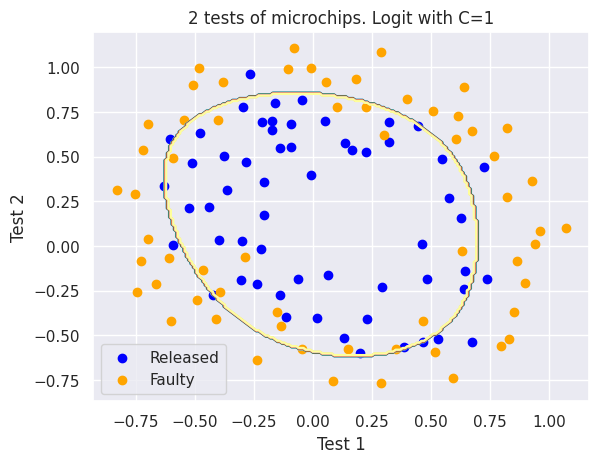





C =  100
Accuracy on training set: 0.873


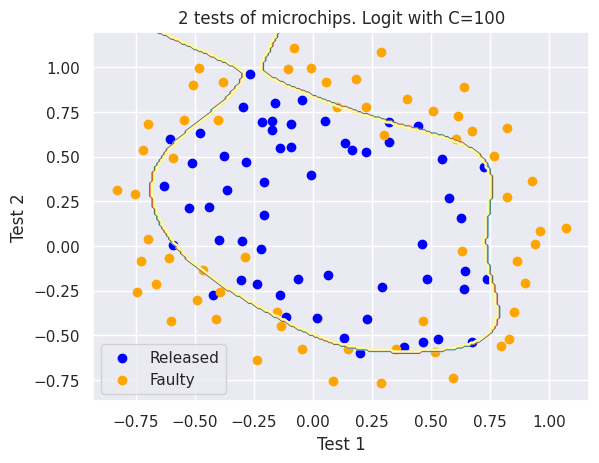





C =  1000
Accuracy on training set: 0.873


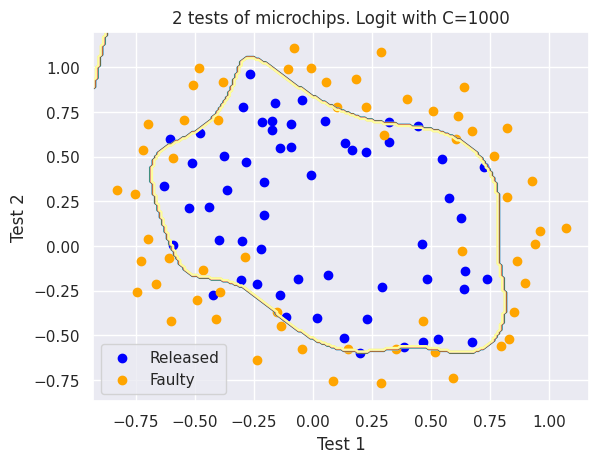





C =  10000
Accuracy on training set: 0.881


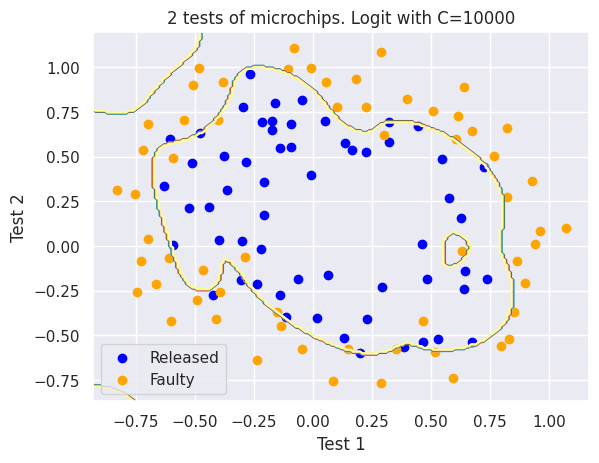

In [ ]:
Cs = [0.5, 1,100, 1000, 10000]

for C in Cs:
    logit = LogisticRegression(C=C, penalty = 'l1', random_state=17, solver='liblinear', max_iter = 1000)
    logit.fit(X_poly, y)
    print('C = ', C)
    print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

    plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title('2 tests of microchips. Logit with C=%s' % C)
    plt.legend()
    plt.show()
    print('\n\n\n')

**Takeaway:** once again, the bigger the C is, the less regularized model we get, and the more complex boundary we obtain.

# GridSearch

**Why:** we will use same strategy (grid search and cross-validation) for finding the best C.

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-2, 3, 500)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1, penalty = 'l1',  solver='liblinear')
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=1)

In [ ]:
print('Best C = ', logit_searcher.C_[0])

Best C =  3.428231493733971


**Takeaway:** in case of the lasso regression C is much lower.

**Learning curve**

In [ ]:
max(np.mean(logit_searcher.scores_[1], axis=0))

0.8221014492753623

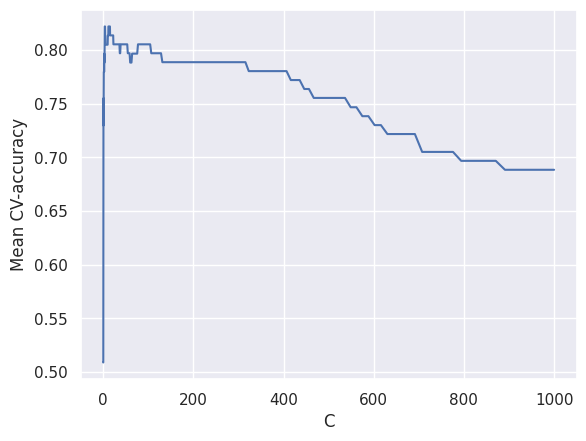

In [ ]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');

# Best model for lasso regression



C =  3.428231493733971
Accuracy on training set: 0.856


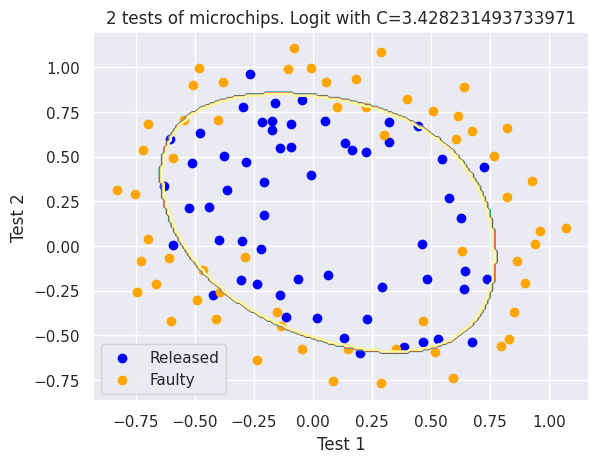

In [ ]:
C = logit_searcher.C_[0]
#C = 1000

logit = LogisticRegression(C=C,  penalty = 'l1', random_state=17, solver='liblinear', max_iter = 1000)
logit.fit(X_poly, y)
print('C = ', C)
print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend()
plt.show()
print('\n\n\n')


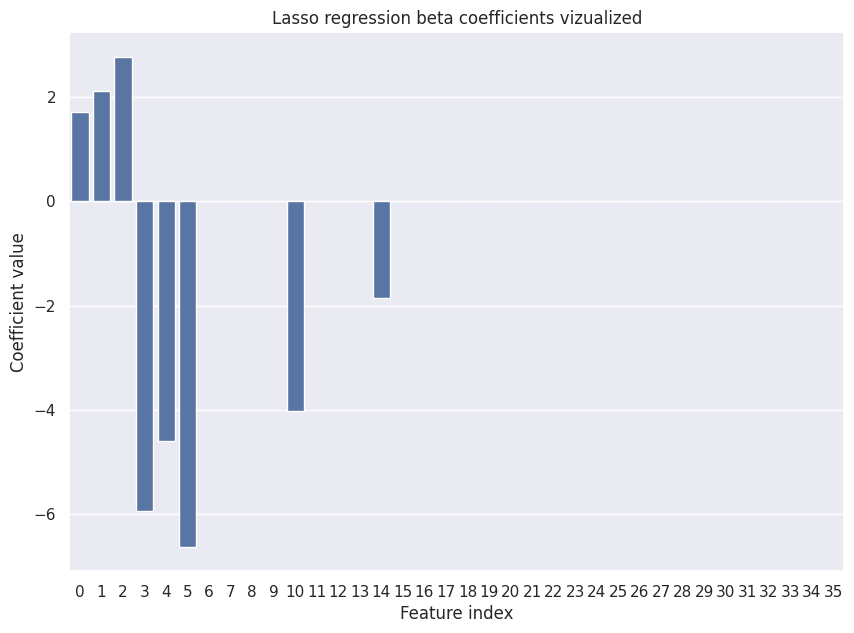

In [ ]:
coefs = (logit.coef_)[0]

plt.figure(figsize=(10, 7))
sns.barplot(y=coefs, x=list(range(len(coefs))))
plt.title('Lasso regression beta coefficients vizualized')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.show()

**Takeaway** we see that lasso regression shrinked most coefficients practically towards zero.

# Elastic net
What if we use both $l_1$ and $l_2$ penalties? What we get is **Elastic Net** regression.

In [ ]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
ElasticNetCV

sklearn.linear_model._coordinate_descent.ElasticNetCV

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(0, 1, 100)
l1_coeffs = np.logspace(-3, 4, 300)

In [ ]:
logit_searcher = ElasticNetCV(alphas=c_values, l1_ratio=l1_coeffs, cv=skf, verbose=1, n_jobs=-1, max_iter = 10000)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=array([ 1.        ,  1.02353102,  1.04761575,  1.07226722,  1.09749877,
        1.12332403,  1.149757  ,  1.17681195,  1.20450354,  1.23284674,
        1.26185688,  1.29154967,  1.32194115,  1.35304777,  1.38488637,
        1.41747416,  1.45082878,  1.48496826,  1.51991108,  1.55567614,
        1.59228279,  1.62975083,  1.66810054,  1.70735265,  1.7475284 ,
        1.78864953,  1.83073828,  1.87381742,  1.91791026,  1.96304065,
        2.00...
       2.89426612e+03, 3.05456825e+03, 3.22374888e+03, 3.40229977e+03,
       3.59073989e+03, 3.78961698e+03, 3.99950910e+03, 4.22102632e+03,
       4.45481252e+03, 4.70154722e+03, 4.96194760e+03, 5.23677054e+03,
       5.52681486e+03, 5.83292359e+03, 6.15598650e+03, 6.49694260e+03,
       6.85678294e+03, 7.23655342e+03, 7.63735792e+03, 8.06036141e+03,
       8.50679342e+03, 8.97795155e+03, 9.47520530e+03, 1.00000000e+04]),
             max_iter=10000, n_jobs=-1, verbose=1)

In [ ]:
print(f'Best l1 ratio: {logit_searcher.l1_ratio_}, best alpha: {logit_searcher.alpha_}')

Best l1 ratio: 0.001, best alpha: 1.0


In [ ]:
print('Elastic net accuracy on training set', logit_searcher.score(X_poly, y))

Elastic net accuracy on training set 0.07373686861808004


In [ ]:
ElasticNet?

Accuracy on training set: 0.653


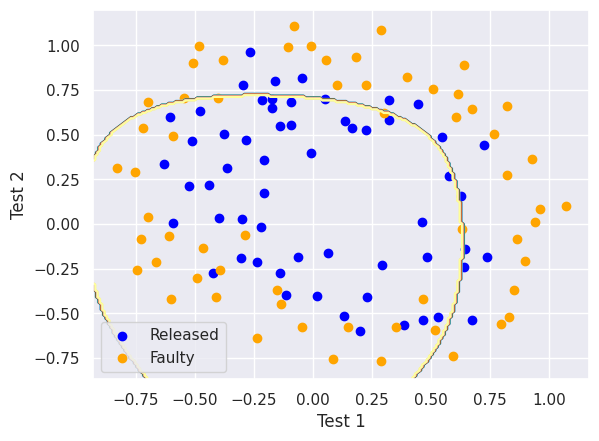

In [ ]:
# C = logit_searcher.C_[0]
#C = 1000

# logit = LogisticRegression(C=C,  penalty = 'l1', random_state=17, solver='liblinear', max_iter = 1000)
# logit = ElasticNet(alpha=1, l1_ratio=0.001)
logit = SGDClassifier(loss="log_loss",l1_ratio=0.5, alpha=1)
logit.fit(X_poly, y)
# print('C = ', C)
print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
# plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend()
plt.show()
print('\n\n\n')

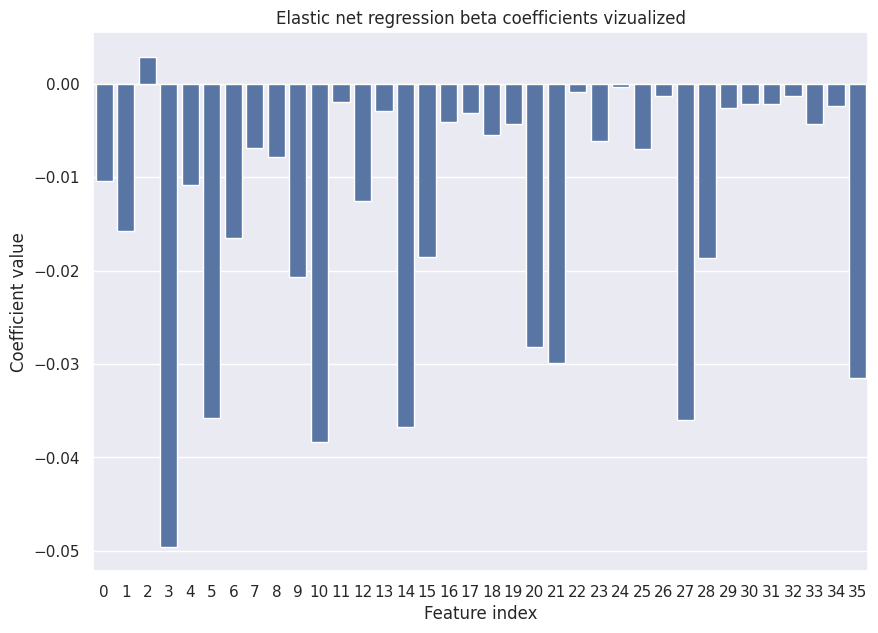

In [ ]:
coefs = (logit.coef_).flatten()

plt.figure(figsize=(10, 7))
sns.barplot(y=coefs, x=list(range(len(coefs))))
plt.title('Elastic net regression beta coefficients vizualized')
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.show()

In [ ]:
coefs

array([[-0.01042239, -0.01578444,  0.00288838, -0.04956112, -0.01088612,
        -0.03579521, -0.01647693, -0.00689512, -0.00780623, -0.02067842,
        -0.03829613, -0.00196036, -0.0125341 , -0.00287449, -0.03678979,
        -0.01849508, -0.00414325, -0.00318088, -0.00553557, -0.00434581,
        -0.02813736, -0.02994337, -0.00091784, -0.00616757, -0.00032434,
        -0.00699436, -0.00126683, -0.0359757 , -0.01865055, -0.0026177 ,
        -0.00219797, -0.00213103, -0.00130755, -0.00432835, -0.00237646,
        -0.03153778]])

In [ ]:
# Let's try same parameters with LR model with saga solver and elasticnet

logit = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.001, C=1.0)
logit.fit(X_poly, y)

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Accuracy on training set: 0.831


/Users/admin/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Exercise
Lasso regression could be used for feature selection. If the coefficient becomes small, we could drop it from the feature subset and build model only on features that correspond to large coefficients.

1. Fit a lasso regression and obtain coefficients with absolute values greater than 0.001
2. Fit a ridge regression using the selected features only
3. Fit a lasso regression using the selected features only
4. Compare the results to previous findings: does using feature selection produce a better accuracy?